# Modèle prédictif pour classifier les attaques réseau - Methode 1
Nathan TBL 


## • Importation des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires et définition des chemins et des colonnes pour les ensembles de données KDD

In [93]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
import numpy as np

train_path = './datasets/KDD/KDDTrain+.txt'
test_path = './datasets/KDD/KDDTest+.txt'
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Mappage des étiquettes
label_mapping = {
    'benign': ['normal'],
    'probe': ['nmap', 'ipsweep', 'portsweep', 'satan', 'mscan', 'saint', 'worm'],
    'r2l': ['ftp_write', 'guess_passwd', 'snmpguess', 'imap', 'spy', 'warezclient', 'warezmaster', 'multihop', 'phf', 'named', 'sendmail', 'xlock', 'xsnoop', 'worm'],
    'u2r': ['ps', 'buffer_overflow', 'perl', 'rootkit', 'loadmodule', 'xterm', 'sqlattack', 'httptunnel'],
    'dos': ['apache2', 'back', 'mailbomb', 'processtable', 'snmpgetattack', 'teardrop', 'smurf', 'land', 'neptune', 'pod', 'udpstorm']
}

# Charger les ensembles de données
train_data = pd.read_csv(train_path, header=None, names=columns)
test_data = pd.read_csv(test_path, header=None, names=columns)

## • Prétraitement des Données
Chargement des ensembles de données, mappage des étiquettes en catégories, et encodage des variables catégorielles avec LabelEncoder.

In [ ]:
# Mapper les étiquettes des attaques aux cinq catégories
def map_labels(label):
    for key, values in label_mapping.items():
        if label in values:
            return key
    return label

train_data['label'] = train_data['label'].apply(map_labels)
test_data['label'] = test_data['label'].apply(map_labels)

# Encoder les variables catégorielles
protocol_encoder = LabelEncoder()
service_encoder = LabelEncoder()
flag_encoder = LabelEncoder()
label_encoder = LabelEncoder()

train_data['protocol_type'] = protocol_encoder.fit_transform(train_data['protocol_type'])
train_data['service'] = service_encoder.fit_transform(train_data['service'])
train_data['flag'] = flag_encoder.fit_transform(train_data['flag'])
train_data['label'] = label_encoder.fit_transform(train_data['label'])

test_data['protocol_type'] = protocol_encoder.transform(test_data['protocol_type'])
test_data['service'] = service_encoder.transform(test_data['service'])
test_data['flag'] = flag_encoder.transform(test_data['flag'])
test_data['label'] = label_encoder.transform(test_data['label'])

# Séparer les caractéristiques et les étiquettes
X_train = train_data.drop(columns=['label', 'difficulty'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label', 'difficulty'])
y_test = test_data['label']

# Standardiser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## • Réduction de la Dimensionnalité avec analyse PCA et Clustering K-Means
Réduction de la dimensionnalité des données avec PCA et application de l'algorithme de clustering K-Means.

In [94]:
# Réduire la dimensionnalité à l'aide de PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Appliquer le clustering K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
y_train_pred = kmeans.fit_predict(X_train_pca)
y_test_pred = kmeans.predict(X_test_pca)

# Récupérer les centroids
centroids = kmeans.cluster_centers_

# Mesurer la performance du clustering
adjusted_rand_index_train = adjusted_rand_score(y_train, y_train_pred)
adjusted_rand_index_test = adjusted_rand_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f'Indice de Rand ajusté sur l\'ensemble d\'entraînement : {adjusted_rand_index_train:.4f}')
print(f'Indice de Rand ajusté sur l\'ensemble de test : {adjusted_rand_index_test:.4f}')
print(f'Accuracy sur l\'ensemble d\'entraînement : {accuracy_train:.4f}')
print(f'Accuracy sur l\'ensemble de test : {accuracy_test:.4f}')

Indice de Rand ajusté sur l'ensemble d'entraînement : 0.6079
Indice de Rand ajusté sur l'ensemble de test : 0.2879
Accuracy sur l'ensemble d'entraînement : 0.8257
Accuracy sur l'ensemble de test : 0.5812


## • Visualisation des Clusters après PCA
Visualisation des clusters après réduction de dimensionnalité avec PCA, en utilisant des graphiques 3D pour montrer les clusters et les centroids.

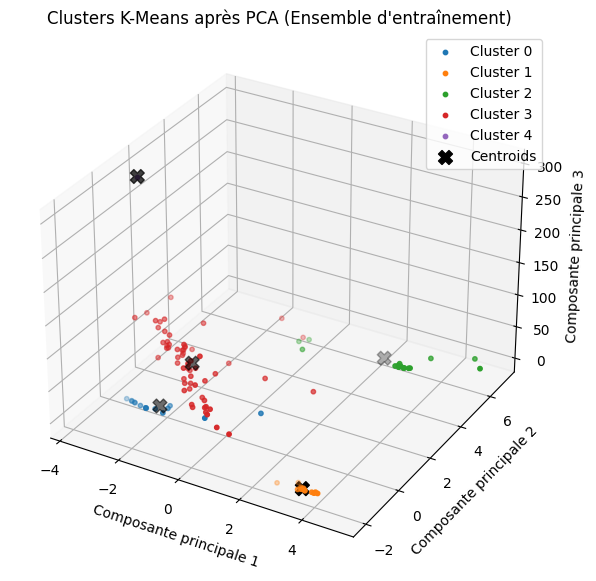

In [102]:
# Visualiser les résultats de la PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Limiter à 15 points par classe pour une meilleure visualisation
unique_labels = np.unique(y_train_pred)
for label in unique_labels:
    label_indices = np.where(y_train_pred == label)[0]
    if len(label_indices) > 70:
        label_indices = np.random.choice(label_indices, 15, replace=False)
    ax.scatter(X_train_pca[label_indices, 0], X_train_pca[label_indices, 1], X_train_pca[label_indices, 2], label=f'Cluster {label}', s=10)

# Ajouter les centroids
centroid_scatter = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', s=100, marker='X', label='Centroids')

# Ajouter la légende
ax.legend()
ax.set_title('Clusters K-Means après PCA (Ensemble d\'entraînement)')
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
plt.show()
